In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primaldual_VPINN import *
from matplotlib.tri import Triangulation
from utility import *
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

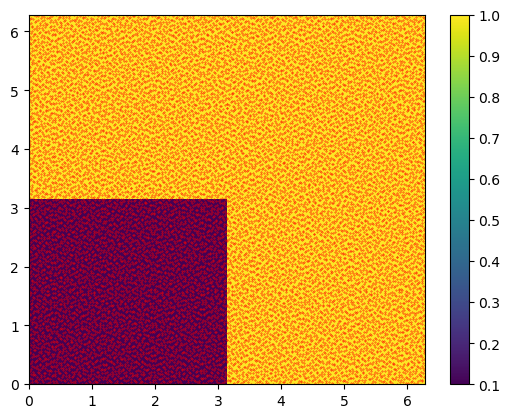

In [3]:
L = 2*np.pi
N = 1024 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x<np.pi)&(y<np.pi), 0.1, 1)
    return a

def A(x):  
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Test functions

## NN-based

In [4]:
N_test = 100
torch.manual_seed(0)
test_functions = [PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L).to(dev) for i in range(N_test)]

In [5]:
# compute G if needed
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(dev)
x = x.to(dev).requires_grad_(True)

G = torch.zeros((N_test, N_test))
g_test = []
for i in range(N_test):
    y_test = test_functions[i](x)
    grad_test = torch.autograd.grad(
                outputs=y_test, inputs=x,
                grad_outputs=torch.ones_like(y_test)
            )[0]
    g_test.append(grad_test.detach())

for i in range(N_test):
    for j in range(i, N_test):
        intgr = compute_int(areas, tri, g_test[i], g_test[j])
        G[i,j] = intgr
        G[j,i] = intgr

torch.save(G, "G_primal_1801.pt")

In [6]:
G = torch.load("G_primal_1801.pt")[:N_test,:N_test]
G_inv = torch.linalg.inv(G).to(dev)

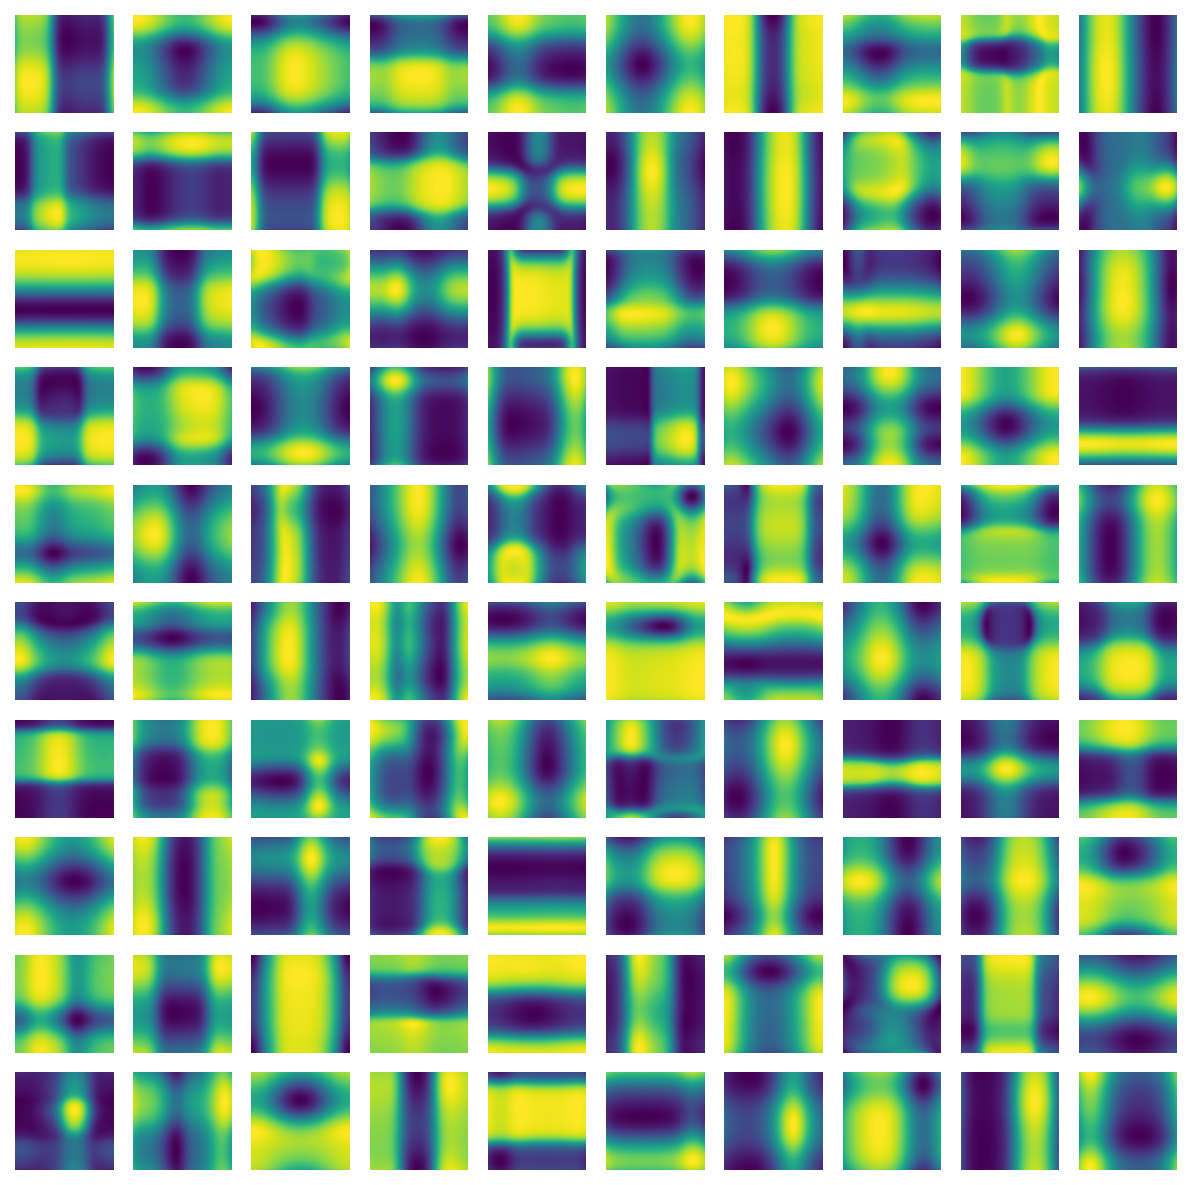

In [14]:
fig, axs = plt.subplots(nrows=10, ncols=N_test//10, figsize=(N_test//10,10), dpi=150)
for i in range(len(test_functions)):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu().detach())
    axs.flat[i].set_axis_off()

In [8]:
net = PINN_2(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 1e-4, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_double_{total_params}'}

Number of parameters: 3602


In [ ]:
net = load_network(net, args['name']+'_39999', args)
net = net.to(dev)

In [9]:
losses_train, losses_val = train(net, loaders, args, A, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  2.96554169e+02, mean val. loss:  3.66245389e-01
Epoch: 1 mean train loss:  2.95569550e+02, mean val. loss:  3.57450366e-01
Epoch: 2 mean train loss:  2.94591644e+02, mean val. loss:  3.49122077e-01
Epoch: 3 mean train loss:  2.93634705e+02, mean val. loss:  3.41283262e-01
Epoch: 4 mean train loss:  2.92662720e+02, mean val. loss:  3.33902091e-01
Epoch: 5 mean train loss:  2.91675140e+02, mean val. loss:  3.26941311e-01
Epoch: 6 mean train loss:  2.90728149e+02, mean val. loss:  3.20379406e-01
Epoch: 7 mean train loss:  2.89775543e+02, mean val. loss:  3.14204127e-01
Epoch: 8 mean train loss:  2.88825165e+02, mean val. loss:  3.08407247e-01
Epoch: 9 mean train loss:  2.87870819e+02, mean val. loss:  3.02982718e-01
Epoch: 10 mean train loss:  2.86935455e+02, mean val. loss:  2.97925413e-01
Epoch: 11 mean train loss:  2.85995514e+02, mean val. loss:  2.93231010e-01
Epoch: 12 mean train loss:  2.85052094e+02, mean val. loss:  2.88895518e-01
Epoch: 13 mean train l

In [11]:
np.save(f'NN_library/training_data/square/VNPINN_double_{total_params}', np.vstack([losses_train, losses_val]))

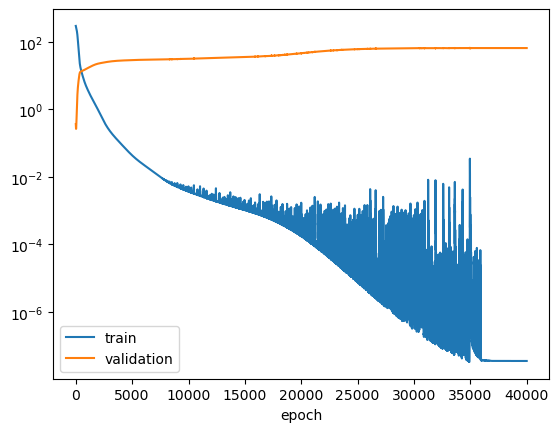

In [10]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [12]:
U = net(grid_data).detach().cpu()
pde_p, pde_d, _, _ = PDE_loss_primal_dual(grid_data, net, A, H1)

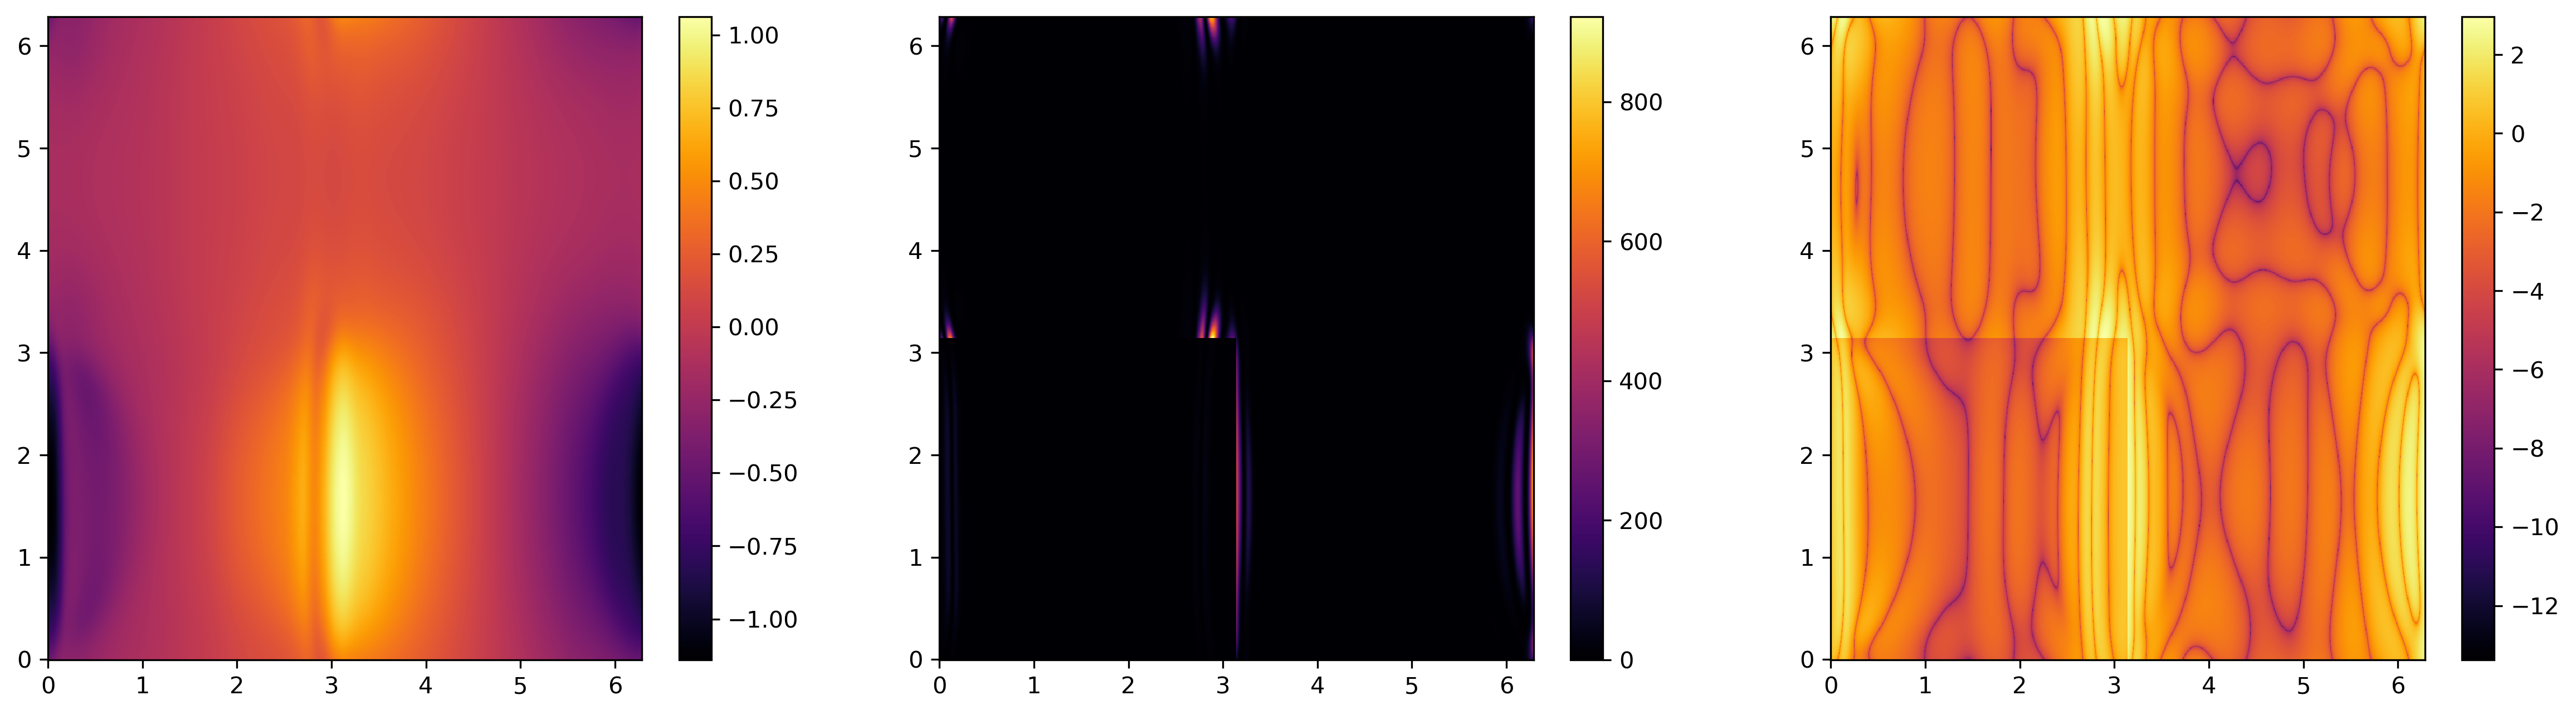

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U[:,0].reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], pde_p.detach().cpu().reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(pde_p.detach().cpu().reshape(N, N)), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

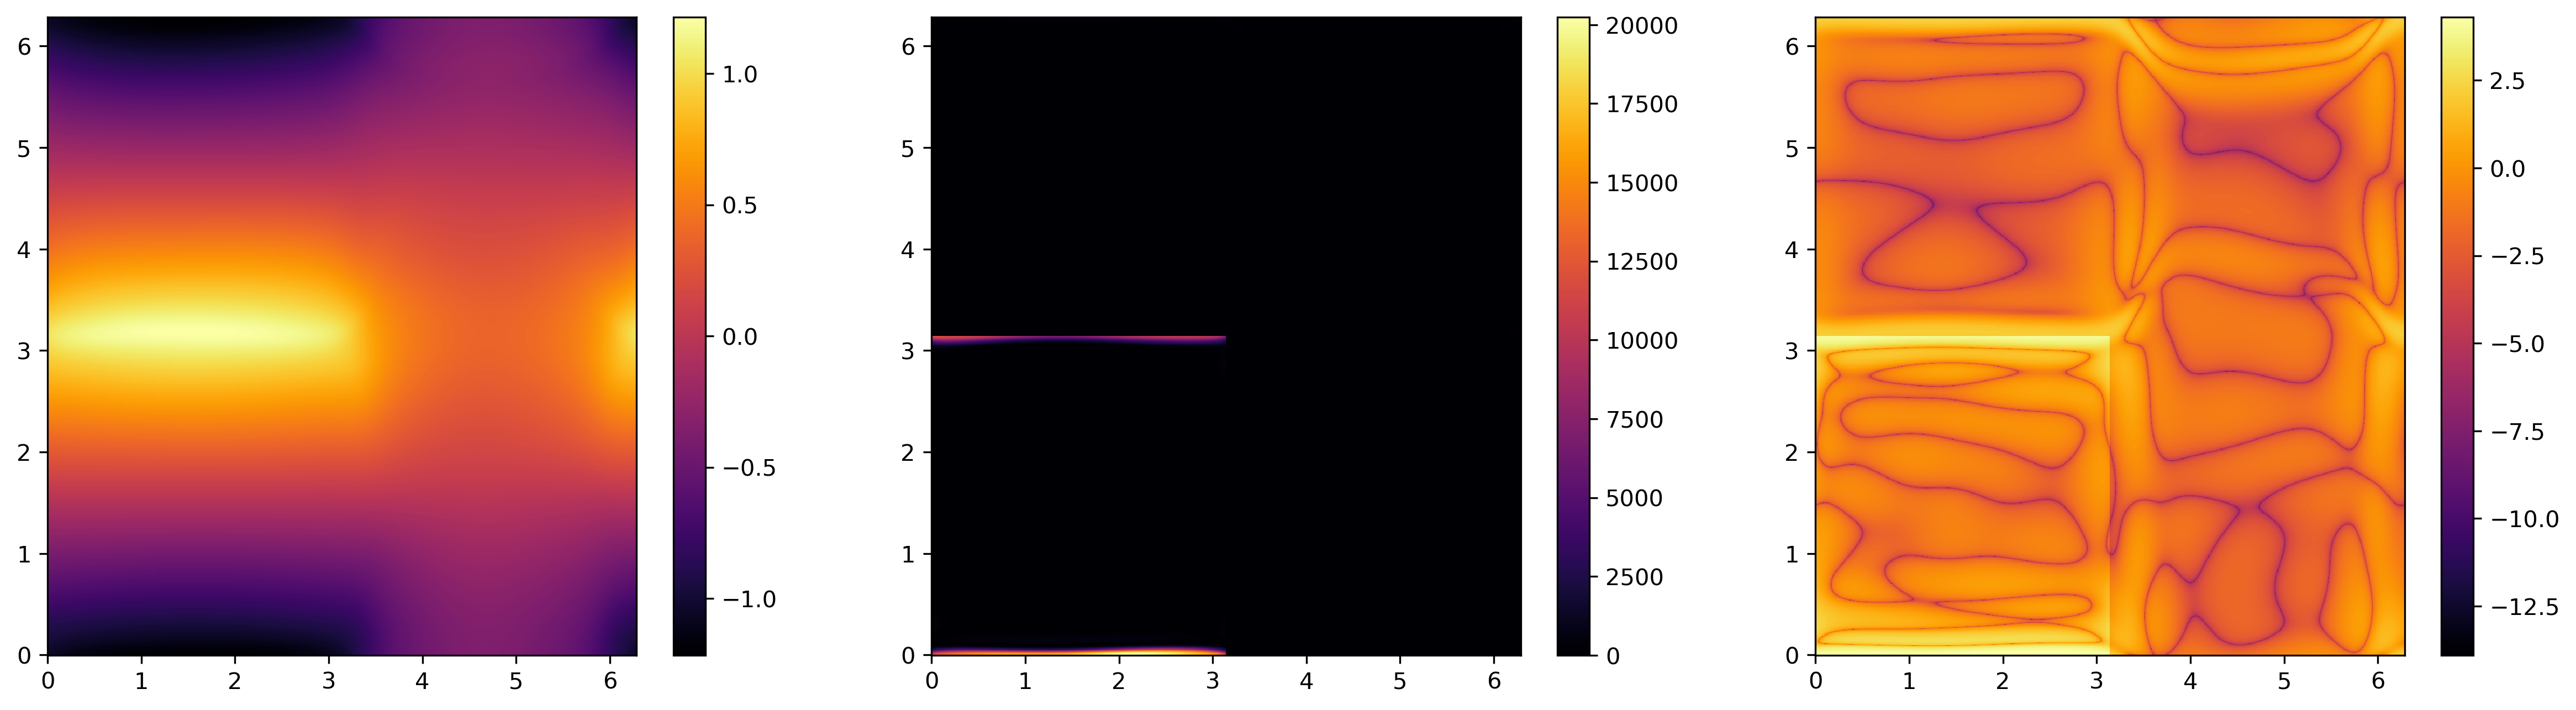

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U[:,1].reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], pde_d.detach().cpu().reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(pde_d.detach().cpu().reshape(N, N)), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [23]:
inputs = data[:].to(dev).requires_grad_(True)
T = net(inputs)
dq1 = torch.autograd.grad(
            outputs=T[:,0], inputs=inputs,
            grad_outputs=torch.ones_like(T[:,0]),
            create_graph=True, retain_graph=True
    )[0].detach()
dq2 = torch.autograd.grad(
            outputs=T[:,1], inputs=inputs,
            grad_outputs=torch.ones_like(T[:,1]),
            create_graph=True, retain_graph=True
    )[0].detach()
curl = torch.zeros_like(dq2)
curl[:,0] = -dq2[:,1]
curl[:,1] = dq2[:,0]
triang = Triangulation(data[:,0], data[:,1])

In [24]:
A_bound = compute_bound(T[:,0], dq1, triang, inputs, A, H1, L)
print(A_bound[0])
print(A_bound[1])

[[ 6.44572098e-01]
 [-3.68497697e-04]]
[[0.60483837]
 [0.0073637 ]]


In [15]:
np.save(f'bounds/square/A_u_VPINN_double_{total_params}.npy', (A_bound[0][0], A_bound[1][0]))

In [25]:
B_bound = compute_bound(T[:,1], curl, triang, inputs, A_inv, H1, L, 'dual')
print(B_bound[0])
print(B_bound[1])

[[6.33225852e-01 1.48609579e-04]
 [1.48609579e-04 6.33225852e-01]]
[[ 0.64608701 -0.05117792]
 [-0.05117792  0.64608701]]


In [26]:
np.save(f'bounds/square/A_l_PINN_double_{total_params}.npy', (B_bound[0][0], B_bound[1][0]))

In [ ]:
np.save(f'bounds/square/A_l_PINN_double_{total_params}.npy', (B_bound[0][0], B_bound[1][0]))